In [69]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [72]:
# load data
df_X = pd.read_csv('../data/X.csv', index_col=0)
df_y = pd.read_csv('../data/y.csv', index_col=0)

# keep selected columns
selected_features = [2056, 2058, 1559, 2083, 1065, 1581, 1583, 1087, 67, 74, 2130, 2662, 2154, 623, 1654, 1656, 1657, 1663, 2182, 2183, 1160, 2184, 2185, 1677, 1678, 1679, 2196, 2717, 2206, 671, 2207, 2208, 2209, 2723, 2212, 2213, 2211, 2725, 2214, 2724, 2218, 2210, 2732, 2221, 174, 2730, 2219, 2220, 2733, 2223, 2224, 2225, 2742, 2736, 2740, 189, 192, 2776, 1243, 734, 2275, 229, 230, 2789, 744, 2791, 742, 743, 745, 761, 1788, 765, 1789, 2817, 2818, 771, 261, 1289, 2828, 1293, 1302, 791, 1303, 1306, 800, 801, 803, 805, 669, 808, 814, 817, 818, 673, 674, 836, 838, 841, 842, 2379, 676, 2382, 849, 851, 853, 854, 855, 2205, 857, 679, 858, 863, 1889, 1890, 1891, 1892, 1894, 1895, 1896, 1897, 1898, 1899, 1902, 1905, 1907, 1910, 888, 385, 386, 2729, 2486, 2734, 2735, 455, 1994, 462, 2017, 487, 489, 2026, 2547, 2549]
new_df_X = df_X.iloc[:, selected_features]

X = new_df_X.to_numpy()
y = df_y.values.ravel()  # 0 is HER2+, 1 is HR+, 2 is Triple Negative

category_labels = ['HER2+', 'HR+', 'Triple Neg']

print(len(selected_features))

142


In [55]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from scipy.stats import randint as sp_randint
import time
import numpy as np

def nested_cv_rfc(x_data, y_targets):
    # Random Forest classifier to be optimized
    rfc = RandomForestClassifier(random_state=2)

    # Define the parameter space for RandomizedSearchCV
    param_dist = {
        "n_estimators": sp_randint(10, 750),
        "max_leaf_nodes": sp_randint(20, 1000),
        "max_depth": sp_randint(20, 500),
        "min_samples_split": sp_randint(2, 250),
        "max_features": sp_randint(3, 100)
    }

    # Number of parameter settings that are sampled
    n_iter_search = 50
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=1)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=2)

    # Execute RandomizedSearchCV
    random_search = RandomizedSearchCV(rfc, param_distributions=param_dist,
                                       n_iter=n_iter_search, scoring=make_scorer(f1_score, average='micro'), cv=inner_cv, verbose=1)

    # Using outer CV for assessing the performance
    outer_scores = cross_val_score(random_search, x_data, y_targets, cv=outer_cv, scoring=make_scorer(f1_score, average='micro'))

    print("Nested CV score (mean):", np.mean(outer_scores))

    # Refitting on the entire dataset (can be omitted if only interested in performance estimate)
    random_search.fit(x_data, y_targets)  # This line will be executed with the best parameters found in the inner CV
    best_params_random = random_search.best_params_
    
    # print("Best parameters from Random Search:", best_params_random)

    # # Defining a narrower search space for GridSearchCV around the best parameters found
    # param_grid = {
    #     "n_estimators": [best_params_random['n_estimators'] - 3, best_params_random['n_estimators'], best_params_random['n_estimators'] + 3],
    #     "max_leaf_nodes": [best_params_random['max_leaf_nodes'] - 5, best_params_random['max_leaf_nodes'], best_params_random['max_leaf_nodes'] + 5],
    #     "max_depth": [best_params_random['max_depth'] - 5, best_params_random['max_depth'], best_params_random['max_depth'] + 5],
    #     "min_samples_split": [best_params_random['min_samples_split'] - 3, best_params_random['min_samples_split'], best_params_random['min_samples_split'] + 3],
    #     "max_features": [max(1, best_params_random['max_features'] - 3), best_params_random['max_features'], best_params_random['max_features'] + 4]
    # }

    # # Ensure parameters are within the original bounds
    # for key in param_grid.keys():
    #     param_grid[key] = [np.max([x, param_dist[key].a]) for x in param_grid[key]]

    # grid_search = GridSearchCV(rfc, param_grid=param_grid, scoring=make_scorer(f1_score, average='micro'), cv=inner_cv, verbose=1)
    # grid_search.fit(x_data, y_targets)
    # best_params_grid = grid_search.best_params_

    # print("Best parameters from Grid Search:", best_params_grid)

    return best_params_random

# Usage: best_params = nested_cv_rfc(x_data, y_targets)


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [57]:
m_rf = RandomForestClassifier(n_estimators = 20, max_features = 3, random_state=42).fit(X_train, y_train)
y_pred = m_rf.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.69      0.85      0.76        13
           1       0.50      0.50      0.50         8
           2       0.67      0.44      0.53         9

    accuracy                           0.63        30
   macro avg       0.62      0.60      0.60        30
weighted avg       0.63      0.63      0.62        30



In [58]:
best_params = nested_cv_rfc(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Fitting 4 folds for each of 50 candidates, totalling 200 fits
Fitting 4 folds for each of 50 candidates, totalling 200 fits
Fitting 4 folds for each of 50 candidates, totalling 200 fits
Fitting 4 folds for each of 50 candidates, totalling 200 fits
Nested CV score (mean): 0.9428571428571428
Fitting 4 folds for each of 50 candidates, totalling 200 fits


In [62]:
# best parameters from RF model from EDA notebook
# using the same hyperparameters here so that the increase in performance is solely due to the feature selection
best_params = {'max_depth': 109, 'max_features': 61, 'max_leaf_nodes': 492, 'min_samples_split': 6, 'n_estimators': 392}

In [63]:
m_rf_optimized = RandomForestClassifier(random_state=42, n_estimators = int(best_params["n_estimators"]), max_depth = int(best_params["max_depth"]), max_leaf_nodes = int(best_params["max_leaf_nodes"]), min_samples_split = int(best_params["min_samples_split"]), max_features = int(best_params["max_features"])).fit(X_train, y_train)
y_pred = m_rf_optimized.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.33      0.38      0.35         8
           2       0.38      0.33      0.35         9

    accuracy                           0.63        30
   macro avg       0.57      0.57      0.57        30
weighted avg       0.63      0.63      0.63        30



In [60]:
print(best_params)

{'max_depth': 418, 'max_features': 55, 'max_leaf_nodes': 544, 'min_samples_split': 7, 'n_estimators': 596}


In [76]:
def plot_confusion_matrix(y_test, y_pred, categories):
    """
    Plots a confusion matrix using seaborn to compare the ground truth labels
    and the model's predictions.

    Parameters:
    - y_test (array-like): True labels.
    - y_pred (array-like): Predictions from the model.
    - categories (list): List of category names for labeling the axes.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create a heatmap from the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Trying different sets of features

### List 2 (features present in 2 or more feature selection methods)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.86      0.75      0.80         8
           2       0.80      0.89      0.84         9

    accuracy                           0.90        30
   macro avg       0.89      0.88      0.88        30
weighted avg       0.90      0.90      0.90        30



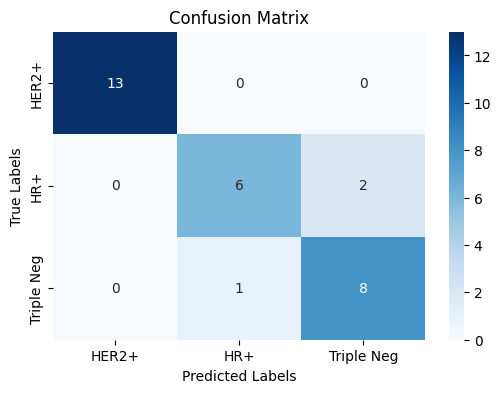

In [77]:
selected_features = [1902, 1956, 1973, 2026, 2058, 2183, 2184, 2207, 2211, 2213, 2547, 2593, 1672, 118, 192, 695, 772, 791, 854, 1061, 1091, 1559, 1643, 1656, 1678, 1900, 2017, 2021, 2024, 2210, 2218, 2750, 2776, 2791, 2817, 2825]
new_df_X = df_X.iloc[:, selected_features]

X = new_df_X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

m_rf_optimized = RandomForestClassifier(random_state=42, n_estimators = int(best_params["n_estimators"]), max_depth = int(best_params["max_depth"]), max_leaf_nodes = int(best_params["max_leaf_nodes"]), min_samples_split = int(best_params["min_samples_split"]), max_features = int(best_params["max_features"])).fit(X_train, y_train)
y_pred = m_rf_optimized.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
plot_confusion_matrix(y_test, y_pred, category_labels)

### List 3 (features present in 3 or more feature selection methods)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.57      0.50      0.53         8
           2       0.60      0.67      0.63         9

    accuracy                           0.77        30
   macro avg       0.72      0.72      0.72        30
weighted avg       0.77      0.77      0.77        30



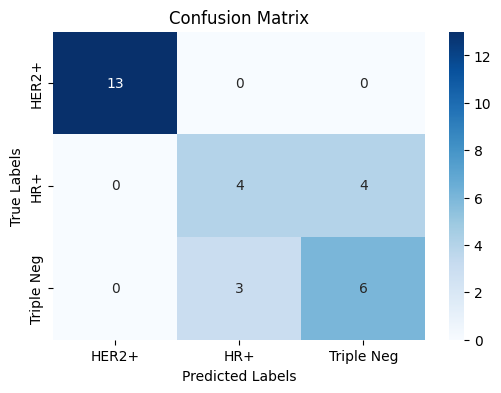

In [79]:
selected_features = [2026, 2184, 2213, 791, 1656, 1678, 1900, 2750]
new_df_X = df_X.iloc[:, selected_features]

X = new_df_X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

m_rf_optimized = RandomForestClassifier(random_state=42, n_estimators = int(best_params["n_estimators"]), max_depth = int(best_params["max_depth"]), max_leaf_nodes = int(best_params["max_leaf_nodes"]), min_samples_split = int(best_params["min_samples_split"]), max_features = int(best_params["max_features"])).fit(X_train, y_train)
y_pred = m_rf_optimized.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
plot_confusion_matrix(y_test, y_pred, category_labels)

### List 4 (features present in 4 or more feature selection methods)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.62      1.00      0.76         8
           2       1.00      0.44      0.62         9

    accuracy                           0.83        30
   macro avg       0.87      0.81      0.79        30
weighted avg       0.90      0.83      0.82        30



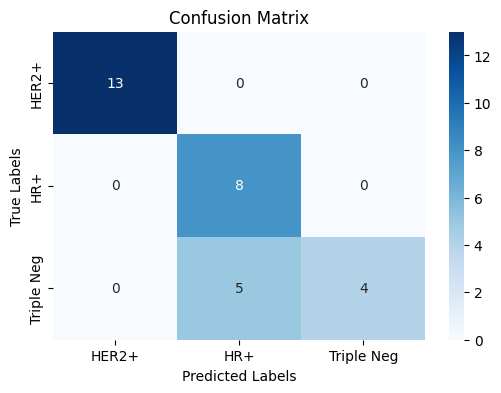

In [80]:
selected_features = [2026, 2184, 2213]
new_df_X = df_X.iloc[:, selected_features]

X = new_df_X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

m_rf_optimized = RandomForestClassifier(random_state=42, n_estimators = int(best_params["n_estimators"]), max_depth = int(best_params["max_depth"]), max_leaf_nodes = int(best_params["max_leaf_nodes"]), min_samples_split = int(best_params["min_samples_split"]), max_features = int(best_params["max_features"])).fit(X_train, y_train)
y_pred = m_rf_optimized.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
plot_confusion_matrix(y_test, y_pred, category_labels)

### List 5 (features present in all feature selection methods)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.46      0.75      0.57         8
           2       0.50      0.22      0.31         9

    accuracy                           0.70        30
   macro avg       0.65      0.66      0.63        30
weighted avg       0.71      0.70      0.68        30



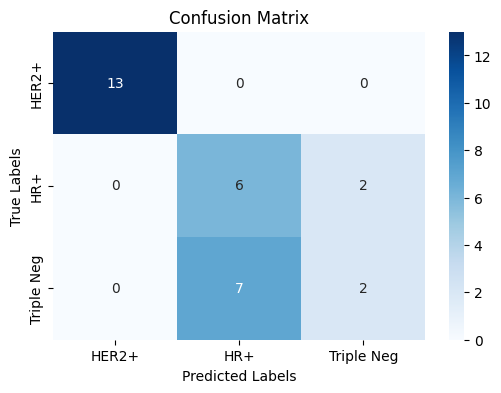

In [82]:
selected_features = [2184]
new_df_X = df_X.iloc[:, selected_features]

X = new_df_X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

m_rf_optimized = RandomForestClassifier(random_state=42, n_estimators = int(best_params["n_estimators"]), max_depth = int(best_params["max_depth"]), max_leaf_nodes = int(best_params["max_leaf_nodes"]), min_samples_split = int(best_params["min_samples_split"]), max_features = int(best_params["max_features"])).fit(X_train, y_train)
y_pred = m_rf_optimized.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
plot_confusion_matrix(y_test, y_pred, category_labels)